# Spotting Bots 
- UDD/MDS18/PP4
- Final Project: 'Studying Twitter User Accounts: Spotting Suspicious Social Bot Behavior'
- Master Candidate: Marcelo Rovai
- Professors:	   
    - Eduardo Graells-Garrido (Supervisor)
    - Loreto Bravo
    - Leo Ferres

## Main Libraries & Setup

In [1]:
import pandas as pd
from pandas.plotting import table
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import re
import botometer
import tweepy

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})

In [ ]:
mashape_key = 'botomer_mashape_key'
twitter_app_auth = {
    'access_token' : "twitter_acc_access_token",
    'access_token_secret' : "twitter_acc_access_token_secret",
    'consumer_key' : "twitter_acc_consumer_key",
    'consumer_secret' : "twitter_acc_consumer_secret",    
}
bom = botometer.Botometer(wait_on_ratelimit = True, mashape_key = mashape_key, **twitter_app_auth)

## Main Functions

In [4]:
def get_twts_per_day(tweets):
    tw_day = []
    for d in range (1, 31):
        tw_day.append(len(tweets[tweets.day == d]))
    return tw_day

In [5]:
def get_max_tweet_day(tweets, user_list):
    max_twt_day = []
    for user_name in user_list:
        t = tweets[tweets.user == user_name].reset_index(drop=True)
        twt_day = get_twts_per_day(t)
        max_twt_day.append(max(twt_day))
    max_tweet_day_user = dict(zip(user_list, max_twt_day))
    max_tweet_day_user = sorted(max_tweet_day_user.items(), key=lambda x:x[1], reverse=True)
    return max_tweet_day_user

In [6]:
def verif_acc_active(user):
    url = "https://twitter.com/"
    try:
        html = urlopen(url+user).read()
        return True 
    except:
        return False

In [7]:
def get_hashtags(tweets):
    hashtags = []
    hashtag_pattern = re.compile(r"#[a-zA-Z]+")
    hashtag_matches = list(tweets['text'].apply(hashtag_pattern.findall))
    hashtag_dict = {}
    cnt = 0
    for match in hashtag_matches:
        for singlematch in match:
            if singlematch not in hashtag_dict.keys():
                hashtag_dict[singlematch] = 1
                cnt +=1
            else:
                hashtag_dict[singlematch] = hashtag_dict[singlematch]+1
                cnt +=1
    hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1], reverse=True)
    return hashtag_ordered_list, len(hashtag_ordered_list), cnt

In [8]:
def get_mentions(tweets):
    mentions = []
    mention_pattern = re.compile(r"@[a-zA-Z_]+")
    mention_matches = list(tweets['text'].apply(mention_pattern.findall))
    mentions_dict = {}
    cnt = 0
    for match in mention_matches:
        for singlematch in match:
            if singlematch not in mentions_dict.keys():
                mentions_dict[singlematch] = 1
                cnt +=1
            else:
                mentions_dict[singlematch] = mentions_dict[singlematch]+1
                cnt +=1
    mentions_ordered_list =sorted(mentions_dict.items(), key=lambda x:x[1], reverse=True)
    return mentions_ordered_list, len(mentions_ordered_list), cnt

In [75]:
def print_user_features(tweets, user_name, prt=True, ver_act=False): 
    if ver_act == False:
        active_acc = "Not checked" 
    else:
        active_acc = verif_acc_active(user_name)
        if verif_acc_active(user_name):
            active_acc = "Active"
        else:
            active_acc = "Not Active"        
        
    t = tweets[tweets.user == user_name].reset_index(drop=True)

    user =  t.user.values[0]
    name = t.name.values[0]
    user_id = t.user_id.values[0]
    default_prof_image = t.default_prof_image.values[0]
    photo_url = t.image.values[0]
    acc_verif = t.verified.values[0]
    location = t.location.values[0]
    default_profile = t.default_profile.values[0]
    descr = t.description.values[0]  
    tws_cnt = t.tweets_cnt.values[0]
    frs_cnt = t.following.values[0]
    fols_cnt = t.followers.values[0]
    fav_cnt = t.favourites.values[0]
    
    if default_prof_image == False:
        if photo_url == 'http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png':
            default_prof_image = True
        else:
            default_prof_image = False
    
    if location == '': 
        local_bol = False
    else:
        local_bol = True
    
    if descr == '':
        descr_bol = False
    else:
        descr_bol = True
    
    tweets_analysed = len(t)
    
    last_tweet_date = t.created_at.values[-1]
    older_tweet_date = t.created_at.values[0]
    account_created_date = t.acc_creation.values[0]
    
    delta = last_tweet_date - account_created_date
    days = delta.astype('timedelta64[D]')
    account_age_days = days / np.timedelta64(1, 'D')
    
    recent_delta = last_tweet_date - older_tweet_date
    days = recent_delta.astype('timedelta64[D]')
    recent_age_days = days / np.timedelta64(1, 'D')  
    
    ave_acc_tw_day = round(tws_cnt/account_age_days, 2)
    ave_recent_tw_day = round(tweets_analysed/recent_age_days, 2)
    tw_day = get_twts_per_day(t)
    max_tweet_day = max(tw_day)
    peak_day = [i for i, j in enumerate(tw_day) if j == max_tweet_day]
    peak_day = peak_day[0] + 1

    if fav_cnt != 0:    
        rt_fv_idx = round(t.retweet_cnt.values[0]/fav_cnt, 2)
    else:
        rt_fv_idx = 0    
    
    if frs_cnt != 0:    
        fl_fw_idx = round(fols_cnt/frs_cnt, 2)
    else:
        fl_fw_idx = 0
    
    RT_tweets = t[t['RT'] == True]
    rt_tweets_cnt =  len(RT_tweets)   
    rt_ratio = round(rt_tweets_cnt/tweets_analysed*100)

    ment_tweets = t[t['num_mentions'] !=0]
    ment_tweets_cnt = len(ment_tweets)
    ment_ratio = round(ment_tweets_cnt/tweets_analysed*100)
    
    hash_tweets = t[t['num_hashtags'] !=0]
    hash_tweets_cnt = len(hash_tweets)
    hash_ratio = round(hash_tweets_cnt/tweets_analysed*100)
    
    mentions, unique_mentions_cnt, ment_cnt = get_mentions(t)
    hashtags, unique_hashtags_cnt, hash_cnt = get_hashtags(t)
    
    try:
        ment_idx = round(unique_mentions_cnt/ment_cnt, 2)
    except:
        ment_idx = 0.0
    try:
        hash_idx = round(unique_hashtags_cnt/hash_cnt, 2) 
    except:
        hash_idx = 0.0
        
    mean_urls = round(t.num_urls.values.mean(), 2)
    mean_lenght = round(t.lenght.values.mean(),0)
 
    # New Features   
    user_len = len(user)
    name_len = len(name)
    descr_len = len(descr)
    
    temp = re.findall(r'\d+', user)
    if len(temp) == 0:
        user_len_num = 0
    else:
        user_len_num = len(temp[0])
    
    try:
        simil_name = 100*(jaccard_similarity(user, name))
    except:
        simil_name = 0          
    
    if frs_cnt != 0:    
        fols_frs_ratio = round(fols_cnt/frs_cnt, 2)
    else:
        fols_frs_ratio = 0
    
    metrics = [
        user, user_id, name, default_prof_image, photo_url, acc_verif, 
        location, local_bol, default_profile, descr, descr_bol, active_acc, tws_cnt, frs_cnt, 
        fols_cnt, fav_cnt, fl_fw_idx, last_tweet_date, older_tweet_date, 
        tweets_analysed, account_age_days, ave_acc_tw_day, 
        ave_recent_tw_day, max_tweet_day, ment_tweets_cnt, hash_tweets_cnt, 
        unique_mentions_cnt, unique_hashtags_cnt, ment_idx, hash_idx, 
        rt_ratio, mean_urls, mean_lenght, recent_age_days, user_len, name_len,
        user_len_num, simil_name, descr_len
    ]
    
    if prt == True:   
        print("\nInfo Data for @" + user)
        print("\nName:                      ", name)
        print("Name Length:               ", name_len)
        print("@user number Numeric Chars:", user_len_num)
        print("@user and name similarity: ", simil_name)
        print("User Id:                   ", user_id)
        print("Default_Photo:             ", default_prof_image)
        print("Photo URL:                 ", photo_url)
        print("Acc Verified:              ", acc_verif)
        print("Has Location:              ", local_bol)
        print("Location:                  ", location)
        print("default_profile:           ", default_profile)
        print("Has Description:           ", descr_bol)
        print("Description:               ", descr) 
        print("Description length:        ", descr_len) 
        print("Account Active:            ", active_acc)

        print("\nNumber of Tweets analyzed:         ", tweets_analysed)
        print("Last Tweet:                        ", last_tweet_date)
        print("Older Tweet Analyzed:              ", older_tweet_date)
        print("Account Active age (in days)        {0:,}".format(account_age_days))
        print("Average recent tweets per day:      {}".format(ave_recent_tw_day))
        print("Maximum Recent Tweets Per Day:      {} at day {}".format(max_tweet_day, peak_day))
        print("Average tweets per day since start: {}".format(ave_acc_tw_day))
        print("Total Tweets since start:           {0:,}".format(tws_cnt))
        print("Followers_count:                    {0:,}".format(fols_cnt))
        print("Friends_following_count             {0:,}".format(frs_cnt))
        print("Followers/Following_index:          {}".format(fl_fw_idx)) 
        print("Favourites (Like) count:            {0:,}".format(fav_cnt))       
        print("Retweet_Like_index:                 {}".format(rt_fv_idx)) 
        print("Retweet Ratio:                      {}%".format(rt_ratio))
        print("unique mentions cnt:                {}".format(unique_mentions_cnt)) 
        print("Mention Ratio:                      {}%".format(ment_ratio))
        print("Mention index:                      {}".format(ment_idx))
        print("unique hashtags cnt:                {}".format(unique_hashtags_cnt))     
        print("Hashtag Ratio:                      {}%".format(hash_ratio))
        print("Hashtag Index:                      {}".format(hash_idx))
        print("Average URLs per tweet:             {}".format(mean_urls))
        print("Average text length per tweet:      {}".format(mean_lenght))
    
    return tw_day, peak_day, metrics, mentions, hashtags

In [10]:
def plot_feature(df, feat, kde=True, prt=False, save_file_name=None, x_max = None):
    f, axes = plt.subplots(ncols=1, figsize=(10, 4))
    sns.despine(left=True)
    sns.distplot(df[feat],
                 color="m",
                 hist=False,
                 kde=kde,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.suptitle(feat + " distribution", fontsize=20)
    plt.xlabel(feat,fontsize=15)
    plt.setp(axes, yticks=[])
    plt.xlim(0, x_max)

    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [76]:
def get_info_data(tweets, user_name, ver_act=True, prt=False):
    tw_day, peak_day, metrics, mentions, hastags = print_user_features(tweets, user_name, ver_act=ver_act)
    
    print("\n \t[Tweets Sample at Peak Day] \n", tweets[(tweets.user == user_name) & (tweets.day == peak_day)].text[:10])
    plot_user_timeline(user_name, tw_day, prt=prt)
    return tw_day, metrics, mentions, hastags

In [12]:
def plot_user_timeline(user_name, tw_day, prt=False):   
    f, axes = plt.subplots(ncols=1, figsize=(10, 4))
    plt.suptitle("@"+user_name+" - Number of Tweets per day", fontsize = 20)
    sns.despine()
    plt.xlabel("day of the month",fontsize=15)
    plt.ylabel("# tweets",fontsize=15)
    plt.bar(range(1, 31), tw_day);
    
    if prt == True:
        plt.savefig("../images/"+user_name+" - Timeline", bbox_inches='tight')

In [13]:
def plot_feat_comp(feat, prt=False, save_file_name=None, x_max = None):
    feat1 = hf[feat]
    feat2 = lf[feat]
    fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
    #fig = plt.figure(figsize = (10,5))
    sns.distplot(feat1,
                 color="m",
                 label='High Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.xlim(0, x_max)
    
    sns.distplot(feat2,
                 color="g",
                 label='Low Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 })
    plt.xlim(0, x_max)
    plt.suptitle(feat+' distribution', fontsize=16)
    sns.despine(left=True)
    plt.setp(axes, yticks=[])
    
    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [14]:
def plot_feat_comp_2_graph(feat, prt=False, save_file_name=None):
    low_freq = lf[feat]
    high_freq = hf[feat]
    f, axes = plt.subplots(ncols=2, figsize=(10, 4))
    sns.despine(left=True)
    sns.distplot(high_freq,
                 color="m",
                 label='High Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 },
                 ax=axes[0])
    sns.distplot(low_freq,
                 color="g",
                 label='Low Frequency',
                 hist=False,
                 kde=True,
                 kde_kws={
                     'shade': True,
                     'linewidth': 3
                 },
                 ax=axes[1])
    plt.suptitle(feat + " distribution", fontsize=16)
    plt.setp(axes, yticks=[])
    
    if prt == True:
        plt.savefig("../images/"+save_file_name, bbox_inches='tight')

In [15]:
def get_botometer_details(user, prt=True):
    try:
        result = bom.check_account(user)
        score = result['scores']
        score_eng = score["english"]
        score_unl = score["universal"]
        cap = result['cap']
        cap_eng = cap["english"]
        cap_unl = cap["universal"]
        cat = result['categories']
        bt_friend = cat['friend']
        bt_network = cat['network']
        bt_sent = cat['sentiment']
        bt_temp = cat['temporal']
        bt_user = cat['user']
        if prt == True:
            print_botometer_details(result)
        return score_eng, score_unl, cap_eng, cap_unl, bt_friend, bt_network, bt_sent, bt_temp, bt_user
    except:
        if prt == True:
            print('{} is not a Twitter user or is blocked'.format(user))
        return 0, 0, 0, 0, 0, 0, 0, 0, 0

In [16]:
def print_botometer_details(result):
    user_data = result['user']
    print("\nBotometer Result for @" + user_data['screen_name'])
    print("\nUser Id:     ", user_data["id_str"])
    score = result['scores']
    print("Score_eng:   ", score["english"])
    print("Score_unl:   ", score["universal"])
    cap = result['cap']
    print("CAP_eng:     ", cap["english"])
    print("CAP_unl:     ", cap["universal"])
    cat = result['categories']
    cat = result['categories']
    print('\nCategories:')
    print("Friend:     ", cat['friend'])
    print("Network:    ", cat['network'])
    print("Sentiment:  ", cat['sentiment'])
    print("Temporal:   ", cat['temporal'])
    print("User:       ", cat['user'])
    print("\nProbability of @{} be a bot is {}%".format(
        user_data['screen_name'], round(score["universal"] * 100)))

## Loading User dataset

In [17]:
ls ../data/

20_tweets_nov_2017.csv             50_user_metrics_final.csv
30_tweets_nov_2017_final.csv       60_user_metrics_label.csv
40_user_metrics.csv                df_user_description.csv
45_user_adit_clean_metrics.csv     select_tweet_feat_description.csv


In [18]:
df_user = pd.read_csv("../data/60_user_metrics_label.csv", lineterminator='\n', low_memory=False)
df_user.shape

(91154, 34)

In [19]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91154 entries, 0 to 91153
Data columns (total 34 columns):
Unnamed: 0             91154 non-null int64
user                   91154 non-null object
default_prof_image     91154 non-null int64
acc_verif              91154 non-null int64
local_bol              91154 non-null int64
default_profile        91154 non-null int64
descr_bol              91154 non-null int64
active_acc             91154 non-null int64
tws_cnt                91154 non-null float64
frs_cnt                91154 non-null float64
fols_cnt               91154 non-null float64
fav_cnt                91154 non-null float64
tweets_analysed        91154 non-null float64
account_age_days       91154 non-null float64
ave_acc_tw_day         91154 non-null int64
ave_recent_tw_day      91154 non-null int64
max_tweet_day          91154 non-null float64
ment_tweets_cnt        91154 non-null float64
hash_tweets_cnt        91154 non-null float64
unique_mentions_cnt    91154 non-nul

In [20]:
del df_user['Unnamed: 0']

In [21]:
df_user.columns

Index(['user', 'default_prof_image', 'acc_verif', 'local_bol',
       'default_profile', 'descr_bol', 'active_acc', 'tws_cnt', 'frs_cnt',
       'fols_cnt', 'fav_cnt', 'tweets_analysed', 'account_age_days',
       'ave_acc_tw_day', 'ave_recent_tw_day', 'max_tweet_day',
       'ment_tweets_cnt', 'hash_tweets_cnt', 'unique_mentions_cnt',
       'unique_hashtags_cnt', 'ment_idx', 'hash_idx', 'rt_ratio', 'mean_urls',
       'mean_lenght', 'recent_age_days', 'user_name_len', 'name_len',
       'user_name_len_num', 'simil_name', 'descr_len', 'fols_frs_ratio',
       'label'],
      dtype='object')

In [22]:
tot_tweets = int(df_user.tweets_analysed.sum())
print("Total Tweets analyzed: {:,}".format(tot_tweets))

Total Tweets analyzed: 1,492,991


In [23]:
data = df_user[['fols_frs_ratio', 'rt_ratio', 'max_tweet_day', 'account_age_days', 'label']]

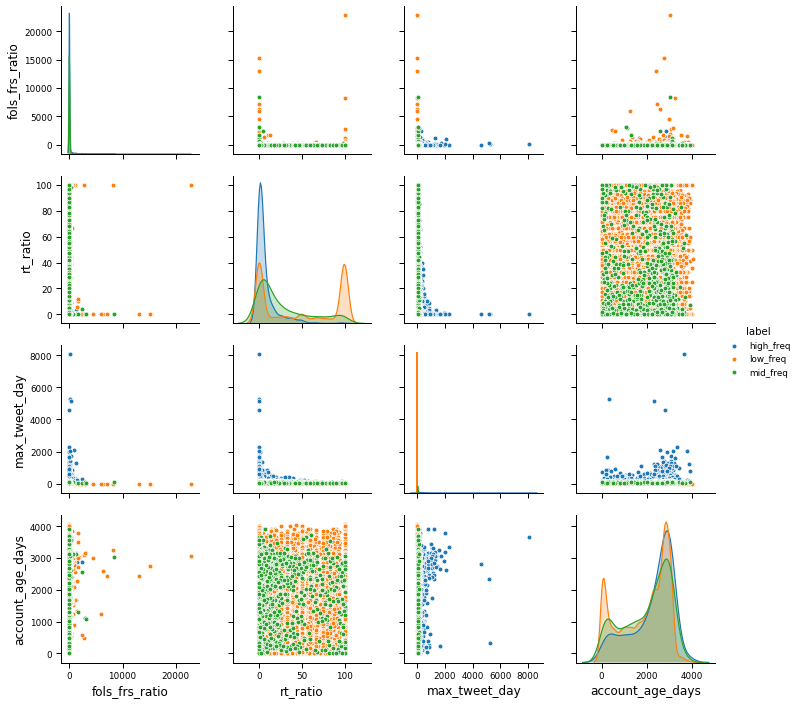

In [24]:
sns.pairplot(data, diag_kind="kde", hue='label');

---

## Loading Tweets Dataset

In [25]:
ls ../data/

20_tweets_nov_2017.csv             50_user_metrics_final.csv
30_tweets_nov_2017_final.csv       60_user_metrics_label.csv
40_user_metrics.csv                df_user_description.csv
45_user_adit_clean_metrics.csv     select_tweet_feat_description.csv


In [26]:
tweets = pd.read_csv("../data/30_tweets_nov_2017_final.csv", lineterminator='\n')
tweets.shape

(1601643, 36)

In [27]:
del tweets['Unnamed: 0']

In [28]:
tweets.description.fillna('', inplace=True)
tweets.location.fillna('', inplace=True)

In [29]:
tweets['created_at'] = pd.to_datetime(tweets['created_at'], infer_datetime_format = "%d/%m/%Y", utc  = False)
tweets['acc_creation'] = pd.to_datetime(tweets['acc_creation'], infer_datetime_format = "%d/%m/%Y", utc  = False)

In [30]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601643 entries, 0 to 1601642
Data columns (total 35 columns):
user_id               1601643 non-null int64
user                  1601643 non-null object
name                  1601576 non-null object
description           1601643 non-null object
verified              1601643 non-null bool
protected             1601643 non-null bool
location              1601643 non-null object
lang                  1601643 non-null object
followers             1601643 non-null int64
following             1601643 non-null int64
favourites            1601643 non-null int64
lists                 1601643 non-null int64
tweets_cnt            1601643 non-null int64
acc_creation          1601643 non-null datetime64[ns, UTC]
default_profile       1601643 non-null bool
default_prof_image    1601643 non-null bool
image                 1601643 non-null object
text                  1601643 non-null object
tweet_id              1601643 non-null int64
created_at     

##  Possible Simple Bots Users Analysis

In [77]:
simple_bots = df_user[(df_user.acc_verif == 0)
                      & (df_user.default_prof_image == 1)
                      & ((df_user.default_profile == 1)
                         | (df_user.descr_bol == 0))
                      & (df_user.max_tweet_day > 72)]
simple_bots.shape

(3, 33)

In [78]:
simple_bots

,user,default_prof_image,acc_verif,local_bol,default_profile,descr_bol,active_acc,tws_cnt,frs_cnt,fols_cnt,...,mean_urls,mean_lenght,recent_age_days,user_name_len,name_len,user_name_len_num,simil_name,descr_len,fols_frs_ratio,label
1381,fedoraletelier,1,0,0,1,0,1,215069,1886,2242,...,0,136,28,14,14,0,100,0,1,mid_freq
6148,Aliciacarafipl3,1,0,0,1,0,1,25781,113,200,...,0,140,29,15,20,1,78,0,2,mid_freq
13523,Dolores09072598,1,0,0,1,0,1,96,300,28,...,0,129,27,15,13,8,67,0,0,mid_freq


In [79]:
simple_bots_users_lst = list(simple_bots.user)

In [80]:
simple_bots_users_lst

['fedoraletelier', 'Aliciacarafipl3', 'Dolores09072598']


Info Data for @fedoraletelier

Name:                       fedoraletelier
Name Length:                14
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    2465345439
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          690
Last Tweet:                         2017-11-29T19:27:32.000000000
Older Tweet Analyzed:               2017-10-31T23:07:51.000000000
Account Active age (in days)        1,333.0
Average recent tweets per day:      24.64
Maximum Recent Tweets Per Day:      85 at day 29
Average tweets per day since start: 161.34
Total Tweets since start:           215,069
Fol

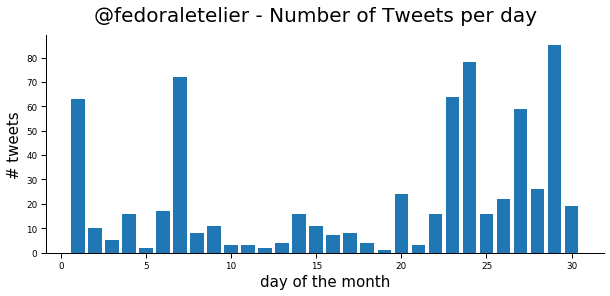

In [81]:
user_name = 'fedoraletelier'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @Aliciacarafipl3

Name:                       Aliciacarafiplanella
Name Length:                20
@user number Numeric Chars: 1
@user and name similarity:  0
User Id:                    801131674402701312
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          747
Last Tweet:                         2017-11-30T22:22:11.000000000
Older Tweet Analyzed:               2017-11-01T21:52:14.000000000
Account Active age (in days)        373.0
Average recent tweets per day:      25.76
Maximum Recent Tweets Per Day:      78 at day 6
Average tweets per day since start: 69.12
Total Tweets since start:           

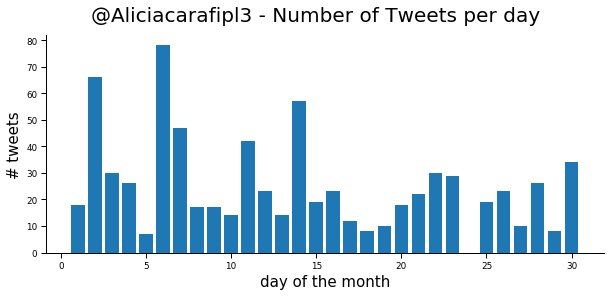

In [82]:
user_name = 'Aliciacarafipl3'
tw_day, metrics, mentions, hastags = get_info_data(tweets, 'Aliciacarafipl3', ver_act=True, prt=True)


Info Data for @Dolores09072598

Name:                       Dolores Nunez
Name Length:                13
@user number Numeric Chars: 8
@user and name similarity:  0
User Id:                    874119200205418497
Default_Photo:              True
Photo URL:                  http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            False
Description:                
Description length:         0
Account Active:             Active

Number of Tweets analyzed:          431
Last Tweet:                         2017-11-30T18:54:12.000000000
Older Tweet Analyzed:               2017-11-03T04:13:46.000000000
Account Active age (in days)        171.0
Average recent tweets per day:      15.96
Maximum Recent Tweets Per Day:      113 at day 23
Average tweets per day since start: 0.56
Total Tweets since start:           96
Fol

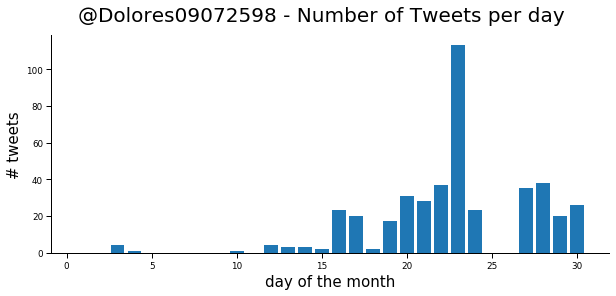

In [83]:
user_name = 'Dolores09072598'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, ver_act=True, prt=True)

### Testing users with Botometer

In [47]:
simple_bots_users_lst

['fedoraletelier', 'Aliciacarafipl3', 'Dolores09072598']

In [48]:
result = get_botometer_details('fedoraletelier')


Info Data for @fedoraletelier

User Id:      2465345439
Score_eng:    0.1807672693005155
Score_unl:    0.300816711527256
CAP_eng:      0.009922300094567935
CAP_unl:      0.030450444848239933

Categories:
Friend:      0.16863713142666406
Network:     0.598331807262351
Sentiment:   0.07214003430676995
Temporal:    0.5682806832825182
User:        0.28373979742013616

Probability of @fedoraletelier be a bot is 30%


In [50]:
result = get_botometer_details('Aliciacarafipl3')


Info Data for @Aliciacarafipl3

User Id:      801131674402701312
Score_eng:    0.23688377651035014
Score_unl:    0.25152334764543
CAP_eng:      0.016566752245969804
CAP_unl:      0.021041094138717433

Categories:
Friend:      0.12674184134165853
Network:     0.2575411738142534
Sentiment:   0.07672623520232581
Temporal:    0.5222044276574785
User:        0.17590968866172144

Probability of @Aliciacarafipl3 be a bot is 25%


In [53]:
result = get_botometer_details('Dolores09072598')

Dolores09072598 is not a Twitter user or is blocked


## Analyze Hi Frequency "Non-Verified" Users

In [84]:
df_user.label.value_counts()

low_freq     89959
mid_freq       798
high_freq      397
Name: label, dtype: int64

In [85]:
hi_freq_users = df_user[(df_user.acc_verif == 0)
                      & (df_user.label == 'high_freq')]
hi_freq_users.shape

(356, 33)

In [86]:
hi_freq_users_lst = list(hi_freq_users.user)

In [87]:
hi_freq_users_order_lst = get_max_tweet_day(tweets, hi_freq_users_lst)

In [88]:
hi_freq_users_order_lst

[('AlbertoMayol', 5163),
 ('Tomaskovacic', 1962),
 ('lagosweber', 1752),
 ('NelsonCL28', 1669),
 ('MaxValdesC', 1605),
 ('paulfontaineb', 1407),
 ('NachoOrtega', 1362),
 ('robertoampuero', 1294),
 ('suberca', 1263),
 ('Monojacoby', 1237),
 ('sergioulloa1', 1205),
 ('lcruzcoke', 1195),
 ('albertoespina', 1139),
 ('gransopi', 1128),
 ('Movilh', 1123),
 ('illapu', 1119),
 ('Flavioqr', 1111),
 ('marcatuvoto', 1103),
 ('GmoRamirez', 1102),
 ('tere_marinovic', 1082),
 ('KarlaEnAccion', 1062),
 ('DraJuguete37', 1014),
 ('dmimica', 986),
 ('DValdebenitoA', 984),
 ('hernan_sr', 976),
 ('manuelotec', 974),
 ('T13valpo', 905),
 ('CarlosAmpuero', 866),
 ('la_tera_vive', 857),
 ('cesarioncamilo', 854),
 ('EstoyConPinera', 848),
 ('andres20der', 842),
 ('Patolinsky', 831),
 ('GiorgioJackson', 830),
 ('S_riesenberg', 826),
 ('Ange_GossowF', 820),
 ('jocanavarro', 800),
 ('Dane_BS', 791),
 ('carlitos_huerta', 772),
 ('AhUeOnAdO', 749),
 ('EncuestaExpress', 748),
 ('jgalemparte', 735),
 ('Chile_Alerta'


Info Data for @AlbertoMayol

Name:                       Alberto Mayol
Name Length:                13
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    337542243
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/892780474829078530/4VeDYUuZ_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Papá de Alessandro, esposo de Claudia, militante del Frente Amplio y de la U. Con el corazón a la izquierda.
Description length:         108
Account Active:             Active

Number of Tweets analyzed:          6930
Last Tweet:                         2017-11-28T15:55:56.000000000
Older Tweet Analyzed:               2017-11-13T01:51:06.000000000
Account Active age (in days)        2,325.0
Average recent tweets per day:      462.0
Maximum Recent Tweets Per Day:     

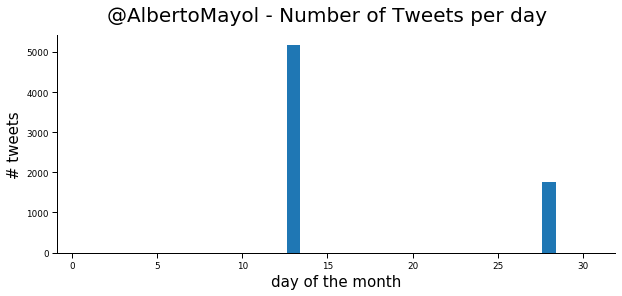

In [89]:
user_name = 'AlbertoMayol'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, ver_act=True, prt=True)

In [61]:
result = get_botometer_details(user_name)


Info Data for @AlbertoMayol

User Id:      337542243
Score_eng:    0.0215615093045025
Score_unl:    0.032398754737074244
CAP_eng:      0.0011785984309163565
CAP_unl:      0.0018655051726169808

Categories:
Friend:      0.12674184134165853
Network:     0.05015681158897715
Sentiment:   0.04364717752402826
Temporal:    0.11725226041842143
User:        0.02392906059496764

Probability of @AlbertoMayol be a bot is 3%



Info Data for @Tomaskovacic

Name:                       Tomas Iturbe Covacic
Name Length:                20
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    94687772
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/892574143840796672/j37U6wrm_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Viña del Mar
default_profile:            False
Has Description:            True
Description:                Ingeniero Comercial | Economista en formación | Coordinador Nacional de @LaBrujulaCL | Viñamarino y Cruzado
Description length:         107
Account Active:             Active

Number of Tweets analyzed:          2062
Last Tweet:                         2017-11-30T16:06:34.000000000
Older Tweet Analyzed:               2017-11-01T15:58:23.000000000
Account Active age (in days)        2,917.0
Average recent tweets per day:      71.1
Maximum Recent Twee

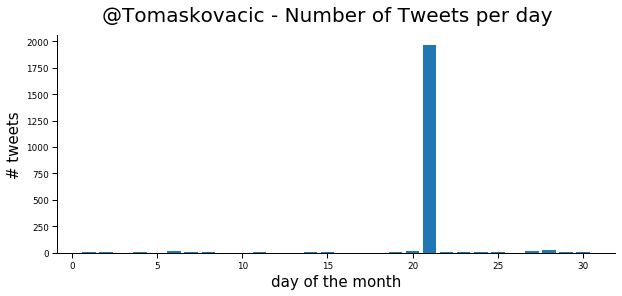

In [90]:
user_name = 'Tomaskovacic'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, ver_act=True, prt=True)


Info Data for @andres20ad

Name:                       Andrés
Name Length:                6
@user number Numeric Chars: 2
@user and name similarity:  0
User Id:                    762803779737616384
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/762806106284515328/y4AvLMUb_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Uno de muchos, que luchan por mejorar este mundo, con mayor justicia, solidaridad e igualdad
Description length:         92
Account Active:             Active

Number of Tweets analyzed:          3060
Last Tweet:                         2017-11-30T23:43:09.000000000
Older Tweet Analyzed:               2017-11-03T02:54:41.000000000
Account Active age (in days)        478.0
Average recent tweets per day:      113.33
Maximum Recent Tweets Per Day:      1583 at day 18
Ave

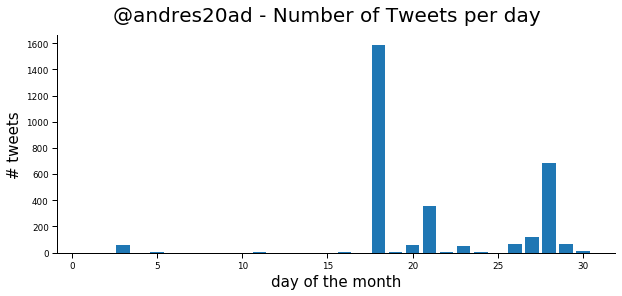

In [91]:
user_name = 'andres20ad'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, ver_act=True, prt=True)


Info Data for @NelsonCL28

Name:                       Nelson Sánchez G.
Name Length:                17
@user number Numeric Chars: 2
@user and name similarity:  0
User Id:                    175420136
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/932340297916387328/uUSFt7NI_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Valparaíso, Chile
default_profile:            False
Has Description:            True
Description:                Praise Kek!
Description length:         11
Account Active:             Active

Number of Tweets analyzed:          1669
Last Tweet:                         2017-11-19T20:20:33.000000000
Older Tweet Analyzed:               2017-11-19T20:20:33.000000000
Account Active age (in days)        2,662.0
Average recent tweets per day:      inf
Maximum Recent Tweets Per Day:      1669 at day 19
Average tweets per day since start: 0.02
Total Tweets since start

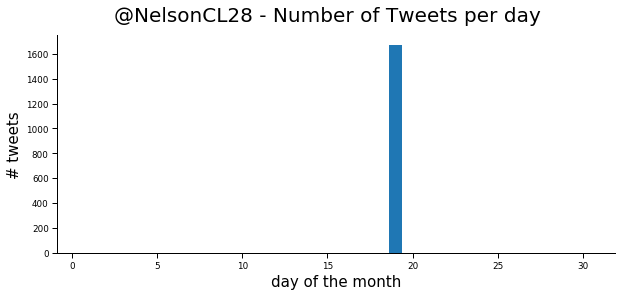

In [92]:
user_name = 'NelsonCL28'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @Ivonomas

Name:                       Ivo Barrientos
Name Length:                14
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    1677545442
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/378800000311704613/57dba5d1d296053000c81f1acbf9cd60_normal.jpeg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                periodista sin título que busca solamente desenmascarar la demagogia que abunda en este espacio. Si me mencionas te hago RT.
Description length:         124
Account Active:             Active

Number of Tweets analyzed:          299
Last Tweet:                         2017-11-30T21:03:14.000000000
Older Tweet Analyzed:               2017-11-01T07:09:21.000000000
Account Active age (in days)        1,566.0
Average recent tweets per day:      10.

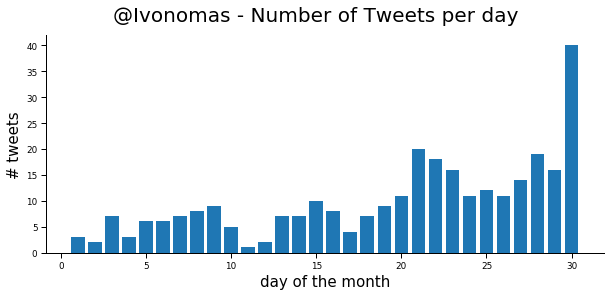

In [93]:
user_name = 'Ivonomas'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)


Info Data for @robertoampuero

Name:                       roberto ampuero
Name Length:                15
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    93268716
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/831334619194744833/nTbjtKh5_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            False
Has Description:            True
Description:                Escritor, Senior Fellow de FPP y Profesor Visitante de U Finis Terrae. Exembajador y ex Ministro Presidente del CNCA de Chile. PhD, MA, IWP Fellow U of Iowa.
Description length:         157
Account Active:             Active

Number of Tweets analyzed:          5332
Last Tweet:                         2017-11-29T15:01:31.000000000
Older Tweet Analyzed:               2017-10-31T18:53:09.000000000
Account Active age (in days)        2,922.0
Average recent tweets pe

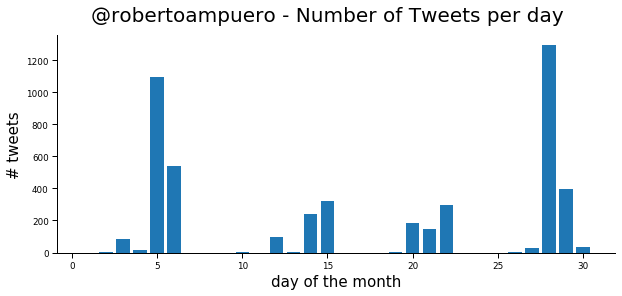

In [94]:
user_name = 'robertoampuero'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)

In [48]:
tweets.text[8]

'En vez de criticar programa de gobierno de @sebastianpinera, gobierno de Bachelet podría ayudar a terminar de redactar el suyo a Guillier.'

In [50]:
result = get_botometer_details(user_name)


Info Data for @robertoampuero

User Id:      93268716
Score_eng:    0.05780718298413593
Score_unl:    0.04811366570775446
CAP_eng:      0.0020801266669107617
CAP_unl:      0.0023079208238384373

Categories:
Friend:      0.1343390390395297
Network:     0.22427046334856154
Sentiment:   0.056219498233927946
Temporal:    0.17904829046331452
User:        0.0435167178071457

Probability of @robertoampuero be a bot is 5%


## Verified account that was canceled by Twitter


Info Data for @dsocial_gob

Name:                       MinDesarrollo Social
Name Length:                20
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    115091645
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/882979542339596291/WEWLSieR_normal.jpg
Acc Verified:               True
Has Location:               True
Location:                   Catedral 1575, Santiago
default_profile:            False
Has Description:            True
Description:                Twitter oficial del Ministerio De Desarrollo Social del @gobiernodechile
Description length:         72
Account Active:             Not Active

Number of Tweets analyzed:          334
Last Tweet:                         2017-11-28T14:18:44.000000000
Older Tweet Analyzed:               2017-11-02T12:31:52.000000000
Account Active age (in days)        2,840.0
Average recent tweets per day:      12.85
Maximum Recent Tweets Per Day:      135 a

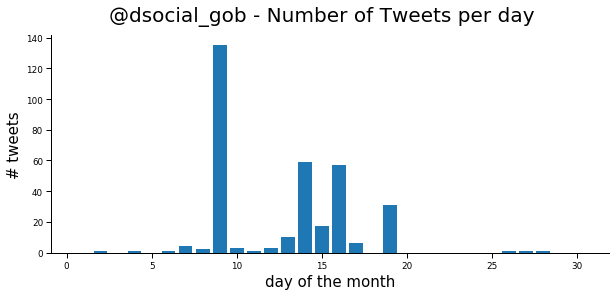

In [95]:
user_name = 'dsocial_gob'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name)

##  Possible Bots by account age in days Analysis

Users posting more than 72 tweets/day and with less than 90 days since creation

In [31]:
new_bots = df_user[(df_user.acc_verif == 0)
                   & (df_user.account_age_days <= 90)
                   & (df_user.max_tweet_day > 72)]

In [32]:
new_bots.shape

(10, 33)

In [33]:
new_bots

,user,default_prof_image,acc_verif,local_bol,default_profile,descr_bol,active_acc,tws_cnt,frs_cnt,fols_cnt,...,mean_urls,mean_lenght,recent_age_days,user_name_len,name_len,user_name_len_num,simil_name,descr_len,fols_frs_ratio,label
312,EncuestaExpress,0,0,1,0,1,1,346,45,32,...,0,138,25,15,18,0,91,117,1,high_freq
938,RResponsablecl,0,0,0,0,1,1,37,345,34,...,1,223,25,14,18,0,91,144,0,high_freq
1810,cazadorandino90,0,0,1,1,1,1,525,134,86,...,0,215,28,15,9,2,17,154,1,mid_freq
2095,Piagutierrezs,0,0,1,1,1,1,1712,2539,1030,...,1,154,27,13,20,0,83,16,0,mid_freq
5059,NathalySeplved3,0,0,1,1,1,1,555,520,294,...,0,176,29,15,15,1,91,97,1,high_freq
11151,ElCentinelaMPE,0,0,1,0,1,1,14,25,9,...,1,166,17,14,12,0,78,69,0,mid_freq
11857,AShumman,0,0,1,1,1,1,6688,4164,308,...,0,127,27,8,17,0,55,11,0,mid_freq
25470,PamelaSoler3,0,0,0,1,1,0,625,353,354,...,0,194,23,12,18,1,13,152,1,mid_freq
73936,Sumate_Guillier,0,0,1,1,1,0,2,32,18,...,1,159,6,15,16,0,100,83,1,high_freq
83687,jav_ast,0,0,0,1,1,1,7,104,42,...,0,155,1,7,16,0,42,77,0,mid_freq


In [34]:
new_bots_users_lst = list(new_bots.user)
new_bots_users_lst

['EncuestaExpress',
 'RResponsablecl',
 'cazadorandino90',
 'Piagutierrezs',
 'NathalySeplved3',
 'ElCentinelaMPE',
 'AShumman',
 'PamelaSoler3',
 'Sumate_Guillier',
 'jav_ast']

PEGABOT Results:
- EncuestaExpress: 76%
- RResponsablecl: 67%
- cazadorandino90: 53%
- Piagutierrezs: 54%
- NathalySeplved3: 71%
- ElCentinelaMPE:45%
- AShumman: Suspended Account
- PamelaSoler3: Not Active
- Sumate_Guillier: Not Active
- jav_ast: 69%

Botometer Results:
- EncuestaExpress: 78%
- RResponsablecl: 20%
- cazadorandino90: 24%
- Piagutierrezs: 18%
- NathalySeplved3: 8%
- ElCentinelaMPE: 28%
- AShumman: Suspended Account
- PamelaSoler3: Not Active
- Sumate_Guillier:: Not Active
- jav_ast: 78%


Info Data for @EncuestaExpress

Name:                       #EncuestaExpressCL
Name Length:                18
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    921483211514970114
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/924012880164540417/cLUUNNEv_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Chile
default_profile:            False
Has Description:            True
Description:                Medio Independiente.
#NoTeQuedesSinVoz!!
Si no votas ¿Con qué cara pides cambios en la sociedad?
#ElPoderEstaEnTuVoto
Description length:         117
Account Active:             Active

Number of Tweets analyzed:          1314
Last Tweet:                         2017-11-26T16:50:34.000000000
Older Tweet Analyzed:               2017-11-01T00:19:55.000000000
Account Active age (in days)        36.0
Average recent tweets per day:      52.56
Maximum

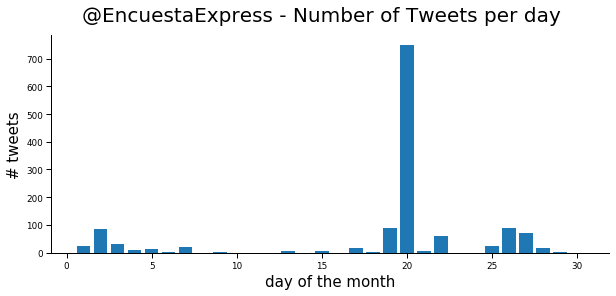

In [63]:
user_name = 'EncuestaExpress'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @RResponsablecl

Name:                       Reg Responsable Cl
Name Length:                18
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    924982201434898433
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/924986249143836674/DKYiJprG_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            False
Has Description:            True
Description:                Buscamos transformar la política de drogas de Chile para regular democráticamente las vías de acceso al Cannabis medicinal y para el uso adulto.
Description length:         144
Account Active:             Active

Number of Tweets analyzed:          422
Last Tweet:                         2017-11-26T12:57:43.000000000
Older Tweet Analyzed:               2017-11-01T01:06:03.000000000
Account Active age (in days)        27.0
Average recent tweets per da

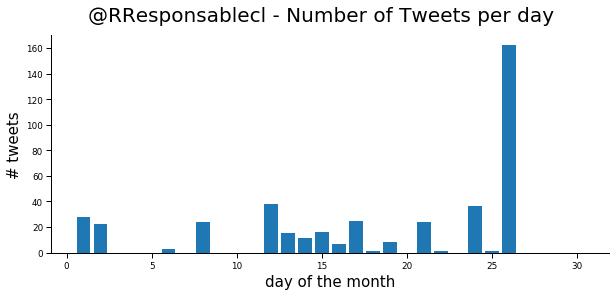

In [64]:
user_name = 'RResponsablecl'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @Piagutierrezs

Name:                       Pilar Gutierrez Soto
Name Length:                20
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    903026378903343110
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/912162615161495553/JvaFizmK_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Puerto Varas, Chile
default_profile:            True
Has Description:            True
Description:                Dirigente social
Description length:         16
Account Active:             Active

Number of Tweets analyzed:          419
Last Tweet:                         2017-11-28T22:36:15.000000000
Older Tweet Analyzed:               2017-11-01T03:08:48.000000000
Account Active age (in days)        89.0
Average recent tweets per day:      15.52
Maximum Recent Tweets Per Day:      131 at day 1
Average tweets per day since start: 19.24
Total 

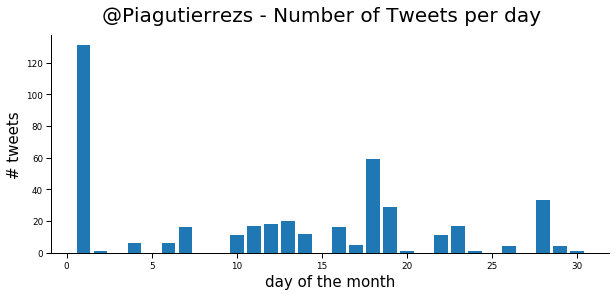

In [65]:
user_name = 'Piagutierrezs'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @NathalySeplved3

Name:                       Sepúlveda Natha
Name Length:                15
@user number Numeric Chars: 1
@user and name similarity:  0
User Id:                    922302808791150592
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/922311874074509313/GO9ffztI_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Metropolitana de Santiago, Chi
default_profile:            True
Has Description:            True
Description:                Más zurda que ayer!!!

Mi otra cuenta @nathalyseplved2   está sin funcionar,. nos leemos por acá.
Description length:         97
Account Active:             Active

Number of Tweets analyzed:          634
Last Tweet:                         2017-11-30T21:14:41.000000000
Older Tweet Analyzed:               2017-11-01T17:44:05.000000000
Account Active age (in days)        38.0
Average recent tweets per day:      21.86
Maximum 

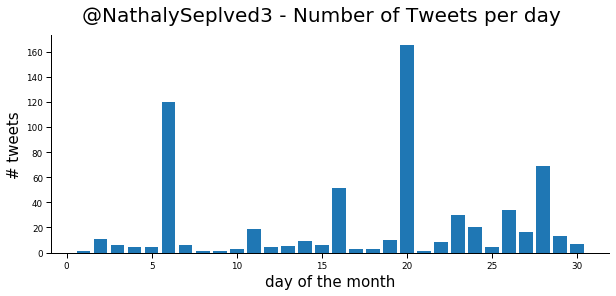

In [66]:
user_name = 'NathalySeplved3'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @ElCentinelaMPE

Name:                       El Centinela
Name Length:                12
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    921445622678478848
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/921446439846383616/VJVnqA3F_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Santiago, Chile
default_profile:            False
Has Description:            True
Description:                Noticias y actualidad desde el Magíster en Periodismo UC-El Mercurio.
Description length:         69
Account Active:             Active

Number of Tweets analyzed:          141
Last Tweet:                         2017-11-20T00:44:21.000000000
Older Tweet Analyzed:               2017-11-02T17:00:04.000000000
Account Active age (in days)        30.0
Average recent tweets per day:      8.29
Maximum Recent Tweets Per Day:      114 at day 19
Avera

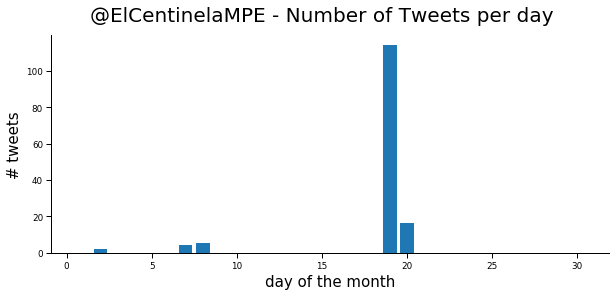

In [67]:
user_name = 'ElCentinelaMPE'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @PamelaSoler3

Name:                       gitanilla andaluza
Name Length:                18
@user number Numeric Chars: 1
@user and name similarity:  0
User Id:                    909141300221501443
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/926431255289266177/CWlqixNW_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                chilena , mamá y esposa ,feliz con mi vida , libre pensante ..aprendiz de bruja y por sobre todo de IZQUIERDA y este es el medio que comparto mis ideas!
Description length:         152
Account Active:             Not Active

Number of Tweets analyzed:          136
Last Tweet:                         2017-11-30T22:36:22.000000000
Older Tweet Analyzed:               2017-11-07T01:43:58.000000000
Account Active age (in days)        75.0
Average recent twee

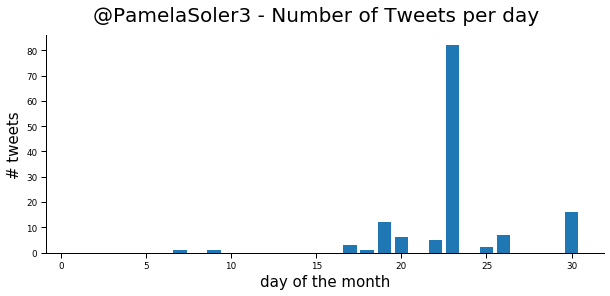

In [68]:
user_name = 'PamelaSoler3'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @AShumman

Name:                       Alexander Shumman
Name Length:                17
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    914950957712146432
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/915001657406173185/XHQaAxZ0_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   ogazparan
default_profile:            True
Has Description:            True
Description:                autodidacta
Description length:         11
Account Active:             Active

Number of Tweets analyzed:          371
Last Tweet:                         2017-11-30T03:46:18.000000000
Older Tweet Analyzed:               2017-11-02T19:51:44.000000000
Account Active age (in days)        58.0
Average recent tweets per day:      13.74
Maximum Recent Tweets Per Day:      122 at day 23
Average tweets per day since start: 115.31
Total Tweets since start:  

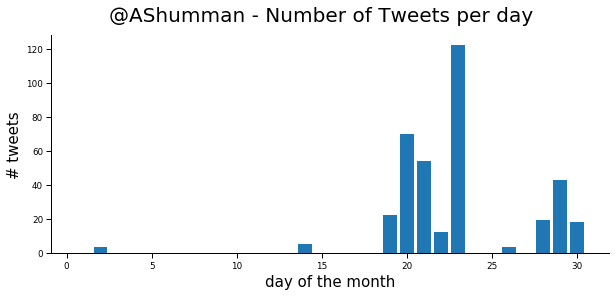

In [70]:
user_name = 'AShumman'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @Sumate_Guillier

Name:                       #SúmateAGuillier
Name Length:                16
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    933384768804110336
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/933385440794632192/MwSY39xo_normal.jpg
Acc Verified:               False
Has Location:               True
Location:                   Chile
default_profile:            True
Has Description:            True
Description:                Súmate a apoyar la candidatura del próximo Presidente de Chile, Alejandro Guillier.
Description length:         83
Account Active:             Not Active

Number of Tweets analyzed:          530
Last Tweet:                         2017-11-29T13:47:07.000000000
Older Tweet Analyzed:               2017-11-22T18:17:45.000000000
Account Active age (in days)        6.0
Average recent tweets per day:      88.33
Maximum Recent Tweets Per Day:      195 at 

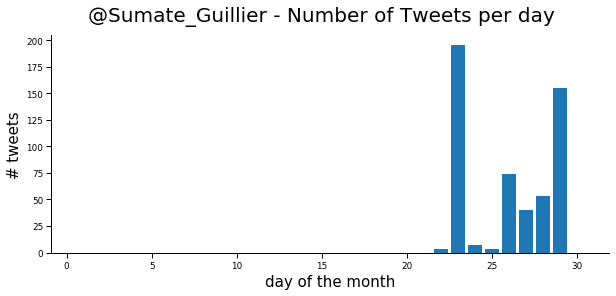

In [71]:
user_name = 'Sumate_Guillier'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)


Info Data for @jav_ast

Name:                       Javier Astudillo
Name Length:                16
@user number Numeric Chars: 0
@user and name similarity:  0
User Id:                    934771590583279616
Default_Photo:              False
Photo URL:                  http://pbs.twimg.com/profile_images/934780786158592000/dj9mU4xY_normal.jpg
Acc Verified:               False
Has Location:               False
Location:                   
default_profile:            True
Has Description:            True
Description:                Estudiante de Medicina UCH - Salud Artes y Cultura Comida Política y Gobierno
Description length:         77
Account Active:             Active

Number of Tweets analyzed:          104
Last Tweet:                         2017-11-27T12:03:15.000000000
Older Tweet Analyzed:               2017-11-27T11:38:45.000000000
Account Active age (in days)        0.0
Average recent tweets per day:      inf
Maximum Recent Tweets Per Day:      104 at day 27
Average tweets pe

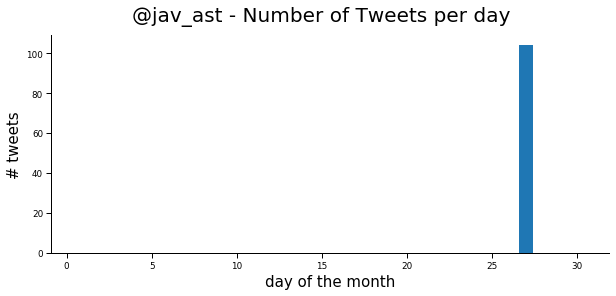

In [74]:
user_name = 'jav_ast'
tw_day, metrics, mentions, hastags = get_info_data(tweets, user_name, prt=True)